In [16]:
import numpy as np
import pandas as pd
import smplotlib
from matplotlib import pyplot as plt  

In [1]:
from dataset import KuruczDataset, load_dataset_file, create_dataloader_from_saved
import torch
train_loader, val_loader, dataset = create_dataloader_from_saved(
    filepath="/Users/jdli/Project/kurucz1/data/kurucz_v5.pt",
    batch_size=128,
    num_workers=0,
    device=torch.device("cpu"),
    validation_split=0.1
)

/Users/jdli/Project/kurucz1/dataset.py:569: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_dict = torch.load(filepath, map_location=device)


In [2]:
import torch # Make sure torch is imported

# Target parameters
target_teff = 5772.0
target_logg = 4.4
target_feh = 0.0
target_afe = 0.0

# Create a target tensor
target_params = torch.tensor([[target_teff, target_logg, target_feh, target_afe]], device=dataset.device)

# Extract the relevant parameters from the dataset
# Ensure they are on the same device as the target
teff = dataset.original['teff'].to(dataset.device)
logg = dataset.original['gravity'].to(dataset.device) # Note: 'gravity' corresponds to logg
feh = dataset.original['feh'].to(dataset.device)
afe = dataset.original['afe'].to(dataset.device)

# Combine dataset parameters into a single tensor (N, 4)
dataset_params = torch.cat([teff, logg, feh, afe], dim=1)

# Calculate the squared Euclidean distance (more efficient than Euclidean distance)
# Broadcasting target_params (1, 4) against dataset_params (N, 4)
distances_sq = torch.sum((dataset_params - target_params)**2, dim=1)

# Find the index of the minimum distance
nearest_index = torch.argmin(distances_sq).item()

# Retrieve the nearest data point parameters
nearest_data_params = dataset_params[nearest_index]

# You can also retrieve the full original data for that index if needed
nearest_full_data = {key: val[nearest_index] for key, val in dataset.original.items()}

print(f"Target parameters: teff={target_teff}, logg={target_logg}, feh={target_feh}, afe={target_afe}")
print(f"Nearest index found: {nearest_index}")
print(f"Nearest data parameters found: teff={nearest_data_params[0].item():.2f}, logg={nearest_data_params[1].item():.2f}, feh={nearest_data_params[2].item():.2f}, afe={nearest_data_params[3].item():.2f}")
# You can access other original data like this:
# nearest_T_profile = dataset.original['T'][nearest_index]
# print(f"Temperature profile (first 5 points): {nearest_T_profile[:5]}")

Target parameters: teff=5772.0, logg=4.4, feh=0.0, afe=0.0
Nearest index found: 5370
Nearest data parameters found: teff=5750.00, logg=4.50, feh=-0.04, afe=0.03


In [3]:
solar_a = {
    'teff':dataset.original['teff'][nearest_index],
    'logg':dataset.original['gravity'][nearest_index],
    'feh':dataset.original['feh'][nearest_index],
    'afe':dataset.original['afe'][nearest_index],
    'rhox':dataset.original['RHOX'][nearest_index],
    'tau':dataset.original['TAU'][nearest_index],
    'temp':dataset.original['T'][nearest_index],
    'xne':dataset.original['XNE'][nearest_index],
}

In [4]:
solar_a

{'teff': tensor([5750.]),
 'logg': tensor([4.5000]),
 'feh': tensor([-0.0400]),
 'afe': tensor([0.0260]),
 'rhox': tensor([4.9241e-04, 6.4469e-04, 8.2081e-04, 1.0256e-03, 1.2642e-03, 1.5430e-03,
         1.8690e-03, 2.2506e-03, 2.6974e-03, 3.2205e-03, 3.8331e-03, 4.5506e-03,
         5.3906e-03, 6.3742e-03, 7.5255e-03, 8.8729e-03, 1.0449e-02, 1.2294e-02,
         1.4451e-02, 1.6974e-02, 1.9923e-02, 2.3370e-02, 2.7398e-02, 3.2105e-02,
         3.7603e-02, 4.4024e-02, 5.1523e-02, 6.0280e-02, 7.0506e-02, 8.2443e-02,
         9.6384e-02, 1.1266e-01, 1.3166e-01, 1.5384e-01, 1.7974e-01, 2.0998e-01,
         2.4528e-01, 2.8649e-01, 3.3459e-01, 3.9074e-01, 4.5627e-01, 5.3275e-01,
         6.2198e-01, 7.2605e-01, 8.4738e-01, 9.8877e-01, 1.1535e+00, 1.3450e+00,
         1.5675e+00, 1.8250e+00, 2.1210e+00, 2.4571e+00, 2.8305e+00, 3.2311e+00,
         3.6408e+00, 4.0357e+00, 4.3946e+00, 4.7021e+00, 4.9522e+00, 5.1545e+00,
         5.3285e+00, 5.4911e+00, 5.6514e+00, 5.8150e+00, 5.9867e+00, 6.1701e

In [7]:
# import pickle

# with open('solar_kurucza1.pkl', 'rb') as f:
#     solar_k = pickle.load(f)
%reload_ext autoreload
%autoreload 2
import torch
from kuruczone import emulator
from model import AtmosphereNetMLPtau
from dataset import KuruczDataset, load_dataset_file, create_dataloader_from_saved
# Load pre-trained model

# Load pre-trained model
# model = emulator.load_from_checkpoint("checkpoints_0409/best_model.pt")
# epoch 300 is the weight that increase the Temp weight to 10
# model = emulator.load_from_checkpoint("checkpoints_0425/checkpoint_epoch_300.pt")
# Load pre-trained model
# model = emulator.load_from_checkpoint("checkpoints_0426_temp/final_model.pt")
model = emulator.load_from_checkpoint("/Users/jdli/Project/kurucz1/checkpoints_v0525_hydro/checkpoint_epoch_100.pt",
                                     dataset_path="/Users/jdli/Project/kurucz1/data/kurucz_v5.pt")

# Create stellar parameter inputs
stellar_params = torch.tensor([[5772.0, 4.44, 0.0, 0.0]])  # Teff, log(g), [Fe/H], [α/Fe]

# Create optical depth grid (optional)
# tau_grid = torch.from_numpy(dataset.original['TAU'][nearest_index])
tau_grid  = dataset.original['TAU'][nearest_index]
# Predict atmospheric structure
atmosphere = model.predict(stellar_params, tau_grid)


Model loaded: trained for 100 epochs, final loss: 766.641004


In [9]:
import numpy as np

# Physical constant
k = 1.380649e-16  # Boltzmann constant (erg/K)

def calculate_xna_from_pressure(pressure, temp, xne):
    """
    Calculate neutral hydrogen density (xna or n_HI) using total pressure and electron density.
    
    Parameters:
    - pressure: Gas pressure in dyn/cm^2, can be scalar or NumPy array
    - temp: Temperature in Kelvin (K), can be scalar or NumPy array
    - xne: Electron density in cm^-3, can be scalar or NumPy array
    
    Returns:
    - xna: Neutral hydrogen density (n_HI) in cm^-3
    """
    # Calculate total particle density
    n_total = pressure / (k * temp)
    
    # For pure hydrogen atmosphere: n_total = n_HI + 2 n_e
    # Thus, n_HI = n_total - 2 n_e
    # xna = n_total - 2 * xne
    xna = n_total
    
    # Ensure n_HI is non-negative
    xna = np.maximum(xna, 0.0)
    
    return xna

def convert_to_sme_format(atlas_data, teff=5777.0, logg=4.485, m_h=0.0, vturb=1.0):
    """
    Convert ATLAS12 model grid data to SME format.
    
    Parameters:
    -----------
    atlas_data : dict
        Dictionary with keys ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD', 'TAU'],
        each containing arrays of 80 depth points.
    teff : float, optional
        Effective temperature (K). Default: 5777.0 (solar-like).
    logg : float, optional
        Surface gravity (log g, cgs units). Default: 4.485.
    m_h : float, optional
        Metallicity [M/H]. Default: 0.0 (solar).
    vturb : float, optional
        Microturbulence velocity (km/s). Default: 1.0.
    
    Returns:
    --------
    sme_atmos : dict
        Dictionary in SME format with stellar parameters, abundances, and atmospheric structure.
    """
    # Constants
    mu = 1.2  # Mean molecular weight (solar photosphere, partially ionized)
    m_H = 1.6735575e-24  # Mass of hydrogen (g)
    k = 1.380649e-16  # Boltzmann constant (erg/K)
    g = 10**logg  # Surface gravity (cm/s^2)
    sigma_eff = 1e-26  # Effective cross-section for H^- (cm^2)

    # Extract input data (80 depth points)
    rhox = atlas_data['RHOX'][0]  # g/cm^2
    temp = atlas_data['T'][0]   # K
    pressure = atlas_data['P'][0]  # dyn/cm^2
    xne = atlas_data['XNE'][0]  # cm^-3
    abross = atlas_data['ABROSS'][0]  # cm^2/g
    tau = atlas_data['TAU'][0]   # Optical depth (dimensionless)

    n_layers = len(rhox)
    # Compute density (rho)
    rho = (pressure * mu * m_H) / (k * temp)  # g/cm^3

    # Compute height (z)
    # Set reference height z = 0 at tau ≈ 1
    ref_idx = np.argmin(np.abs(tau - 1.0))
    z_ref = 0.0
    dRHOX = np.diff(rhox)  # Shape: (79,)
    dz = -dRHOX / rho[:-1]  # Shape: (79,)
    
    # Initialize height array
    height = np.zeros(n_layers)
    height[ref_idx] = z_ref
    # Integrate outward (i > ref_idx)
    for i in range(ref_idx, n_layers-1):
        height[i+1] = height[i] + dz[i]
    # Integrate inward (i < ref_idx)
    for i in range(ref_idx-1, -1, -1):
        height[i] = height[i+1] - dz[i]

    # Compute XNA (number density of absorbers)
    # kappa_vol = abross * rho  # cm^-1
    # xna = kappa_vol / sigma_eff  # cm^-3
    xna = calculate_xna_from_pressure(pressure, temp, xne)

    # Solar abundances (from your SME example)
    abundances = {
        'H': 12.000, 'He': 12.114, 'Li': 1.046, 'Be': 1.376, 'B': 2.696,
        'C': 8.386, 'N': 7.776, 'O': 8.656, 'F': 4.556, 'Ne': 7.836,
        'Na': 6.166, 'Mg': 7.526, 'Al': 6.366, 'Si': 7.506, 'P': 5.356,
        'S': 7.136, 'Cl': 5.496, 'Ar': 6.176, 'K': 5.076, 'Ca': 6.306,
        'Sc': 3.166, 'Ti': 4.896, 'V': 3.996, 'Cr': 5.636, 'Mn': 5.386,
        'Fe': 7.446, 'Co': 4.916, 'Ni': 6.226, 'Cu': 4.206, 'Zn': 4.596,
        'Ga': 2.876, 'Ge': 3.576, 'As': 2.286, 'Se': 3.326, 'Br': 2.556,
        'Kr': 3.246, 'Rb': 2.596, 'Sr': 2.916, 'Y': 2.206, 'Zr': 2.576,
        'Nb': 1.416, 'Mo': 1.916, 'Tc': -7.964, 'Ru': 1.836, 'Rh': 1.116,
        'Pd': 1.656, 'Ag': 0.936, 'Cd': 1.766, 'In': 1.596, 'Sn': 1.996,
        'Sb': 0.996, 'Te': 2.186, 'I': 1.506, 'Xe': 2.236, 'Cs': 1.066,
        'Ba': 2.166, 'La': 1.126, 'Ce': 1.696, 'Pr': 0.576, 'Nd': 1.446,
        'Pm': -7.964, 'Sm': 0.996, 'Eu': 0.516, 'Gd': 1.106, 'Tb': 0.276,
        'Dy': 1.136, 'Ho': 0.506, 'Er': 0.926, 'Tm': -0.004, 'Yb': 1.076,
        'Lu': 0.056, 'Hf': 0.876, 'Ta': -0.174, 'W': 1.106, 'Re': 0.226,
        'Os': 1.246, 'Ir': 1.376, 'Pt': 1.636, 'Au': 1.006, 'Hg': 1.126,
        'Tl': 0.896, 'Pb': 1.996, 'Bi': 0.646, 'Po': -7.964, 'At': -7.964,
        'Rn': -7.964, 'Fr': -7.964, 'Ra': -7.964, 'Ac': -7.964, 'Th': 0.056,
        'Pa': -7.964, 'U': -0.524, 'Np': -7.964, 'Pu': -7.964, 'Am': -7.964,
        'Cm': -7.964, 'Bk': -7.964, 'Cf': -7.964, 'Es': -7.964
    }

    # Construct opflag (example: 1 for used layers, 0 for extrapolated or unused)
    opflag = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0]

    # SME atmosphere dictionary
    sme_atmos = {
        'teff': teff,
        'logg': logg,
        'abund': f'[M/H]={m_h:.3f} applied to abundance pattern. Values below are abundances.\n' +
                 '  '.join([f'{k:3} {v:7.3f}' for k, v in abundances.items()]),
        'vturb': vturb,
        'lonh': 1.5,  # Hydromagnetic pressure parameter (from your example)
        'method': 'grid',  # Interpolation method
        'geom': 'PP',  # Plane-parallel geometry
        'radius': 1.0,  # Stellar radius (normalized or in solar units, adjust if needed)
        'height': -height,  # cm
        'opflag': opflag,  # Flags for layers
        'wlstd': 5000.0,  # Reference wavelength for TAU (Å)
        'depth': 'RHOX',  # Depth scale
        'interp': 'TAU',  # Interpolation method for SME
        'rhox': rhox,  # g/cm^2
        'tau': tau,  # Optical depth
        'temp': temp,  # K
        'rho': rho,  # g/cm^3
        'xna': xna,  # cm^-3
        'xne': xne  # cm^-3
    }

    return sme_atmos

solar_k = convert_to_sme_format(atmosphere, teff=5772.0, logg=4.44, m_h=0.0, vturb=1.0)

In [10]:
solar_k

{'teff': 5772.0,
 'logg': 4.44,
 'abund': '[M/H]=0.000 applied to abundance pattern. Values below are abundances.\nH    12.000  He   12.114  Li    1.046  Be    1.376  B     2.696  C     8.386  N     7.776  O     8.656  F     4.556  Ne    7.836  Na    6.166  Mg    7.526  Al    6.366  Si    7.506  P     5.356  S     7.136  Cl    5.496  Ar    6.176  K     5.076  Ca    6.306  Sc    3.166  Ti    4.896  V     3.996  Cr    5.636  Mn    5.386  Fe    7.446  Co    4.916  Ni    6.226  Cu    4.206  Zn    4.596  Ga    2.876  Ge    3.576  As    2.286  Se    3.326  Br    2.556  Kr    3.246  Rb    2.596  Sr    2.916  Y     2.206  Zr    2.576  Nb    1.416  Mo    1.916  Tc   -7.964  Ru    1.836  Rh    1.116  Pd    1.656  Ag    0.936  Cd    1.766  In    1.596  Sn    1.996  Sb    0.996  Te    2.186  I     1.506  Xe    2.236  Cs    1.066  Ba    2.166  La    1.126  Ce    1.696  Pr    0.576  Nd    1.446  Pm   -7.964  Sm    0.996  Eu    0.516  Gd    1.106  Tb    0.276  Dy    1.136  Ho    0.506  Er    0.926  T

In [11]:
# save to dict
import pickle
with open('solar_kurucza1_v3.pkl', 'wb') as f:
    pickle.dump(solar_k, f)

In [13]:
import pandas as pd

solar_marcs = pd.read_csv("marcs_sun.csv")
solar_marcs.head()

,height,rhox,tau,temp,rho,xna,xne
0,-3.289910e+10,0.012628,0.000019,4097.871363,1.287828e-09,6.119343e+14,4.794994e+10
1,1.081254e+01,0.016311,0.000030,4141.287858,1.647512e-09,7.828506e+14,6.143776e+10
2,7.278868e+16,0.021038,0.000046,4185.888870,2.104151e-09,9.998278e+14,7.863457e+10
3,1.081254e+01,0.027119,0.000071,4231.035648,2.685199e-09,1.275914e+15,1.005566e+11
4,-1.669893e+23,0.034938,0.000110,4276.392672,3.424434e-09,1.627149e+15,1.284548e+11


In [ ]:
temp = atmosphere['T'][:3]  # Temperature in K
xne  = atmosphere['XNE'][:3]  # Electron density in cm^-3
pressure = atmosphere['P'][:3]  # Pressure in dyn/cm^2
# Calculate xna
xna = calculate_xna_from_pressure(pressure, temp, xne)
print("Neutral hydrogen density (cm^-3):", xna)

Neutral hydrogen density (cm^-3): [[2.37746531e+13 3.97614776e+13 4.86577139e+13 5.88504011e+13
  7.06219543e+13 8.43712016e+13 1.00533432e+14 1.19594614e+14
  1.42099849e+14 1.68660597e+14 1.99970238e+14 2.36797838e+14
  2.79995612e+14 3.30524141e+14 3.89454749e+14 4.57997327e+14
  5.37520895e+14 6.29586438e+14 7.36007339e+14 8.58869241e+14
  1.00058202e+15 1.16399050e+15 1.35238749e+15 1.56967807e+15
  1.82043746e+15 2.11010092e+15 2.44517213e+15 2.83332443e+15
  3.28400045e+15 3.80821409e+15 4.41957772e+15 5.13442939e+15
  5.97299276e+15 6.95913229e+15 8.12218259e+15 9.49643898e+15
  1.11226478e+16 1.30477338e+16 1.53255052e+16 1.80155367e+16
  2.11827744e+16 2.48951702e+16 2.92201872e+16 3.42219021e+16
  3.99546033e+16 4.64601301e+16 5.37532981e+16 6.18169704e+16
  7.05924475e+16 7.99533846e+16 8.96861670e+16 9.94613838e+16
  1.08822841e+17 1.17157147e+17 1.23754578e+17 1.28082719e+17
  1.30073248e+17 1.30030556e+17 1.28359496e+17 1.25664653e+17
  1.22923364e+17 1.21187880e+17 1.21

Text(0, 0.5, '$X_{\\rm Na}$')

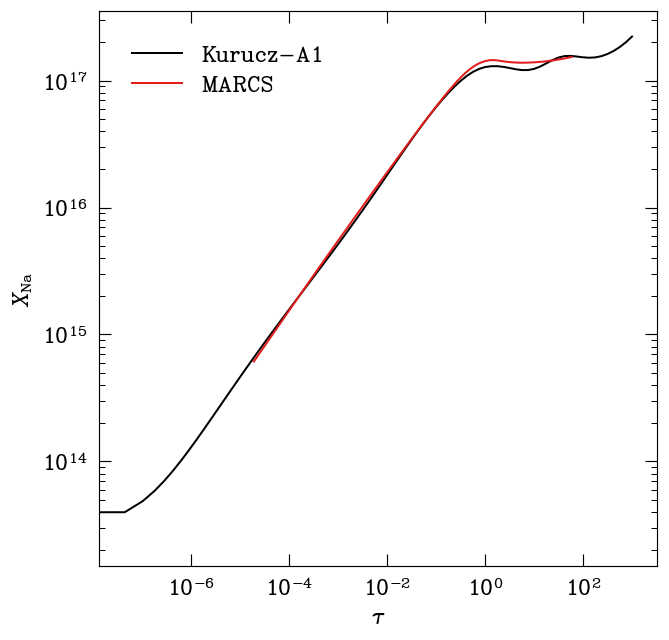

In [17]:
plt.plot(atmosphere['TAU'].reshape(-1), xna.reshape(-1), label='Kurucz-A1')
plt.plot(solar_marcs['tau'], solar_marcs['xna'], label='MARCS')
plt.legend(
    
)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\tau$")
plt.ylabel(r"$X_{\rm Na}$")

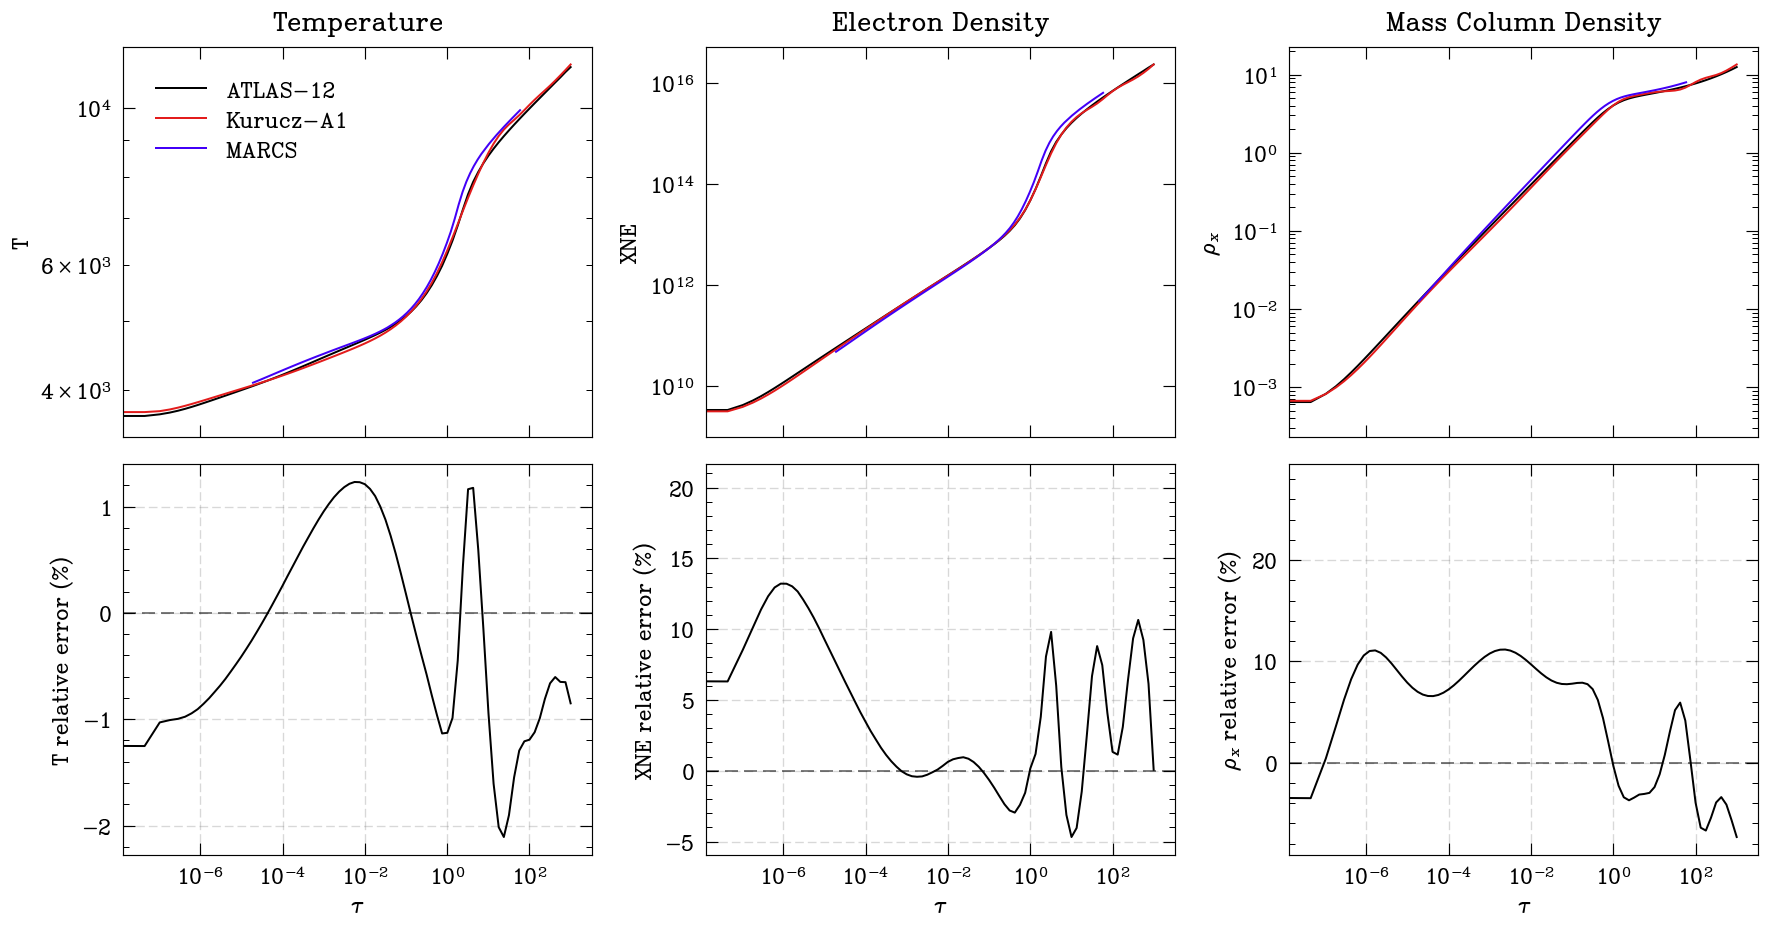

In [18]:
# Create a 2×3 subplot layout (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex='col')

# Top row - original comparison plots
ax1, ax2, ax3 = axs[0]
ax1.plot(solar_a['tau'], solar_a['temp'], label='ATLAS-12')
ax1.plot(solar_k['tau'], solar_k['temp'], label='Kurucz-A1')
ax1.plot(solar_marcs['tau'], solar_marcs['temp'], label='MARCS')
ax1.set_ylabel(r'T')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.set_title('Temperature')

ax2.plot(solar_a['tau'], solar_a['xne'], label='ATLAS-12')
ax2.plot(solar_k['tau'], solar_k['xne'], label='Kurucz-A1')
ax2.plot(solar_marcs['tau'], solar_marcs['xne'], label='MARCS')
ax2.set_ylabel(r'XNE')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Electron Density')

ax3.plot(solar_a['tau'], solar_a['rhox'], label='ATLAS-12')
ax3.plot(solar_k['tau'], solar_k['rhox'], label='Kurucz-A1')
ax3.plot(solar_marcs['tau'], solar_marcs['rhox'], label='MARCS')
ax3.set_ylabel(r'$\rho_x$')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title('Mass Column Density')

# Bottom row - relative error plots
ax4, ax5, ax6 = axs[1]

# Create interpolation functions for ATLAS-12 data
from scipy.interpolate import interp1d

# Create common tau grid (using Kurucz's tau values)
common_tau = solar_k['tau']

# Create interpolation functions for ATLAS-12 data
f_temp_a = interp1d(solar_a['tau'], solar_a['temp'], bounds_error=False, fill_value='extrapolate')
f_xne_a = interp1d(solar_a['tau'], solar_a['xne'], bounds_error=False, fill_value='extrapolate')
f_rhox_a = interp1d(solar_a['tau'], solar_a['rhox'], bounds_error=False, fill_value='extrapolate')

# Calculate interpolated ATLAS-12 values at common tau points
temp_a_interp = f_temp_a(common_tau)
xne_a_interp = f_xne_a(common_tau)
rhox_a_interp = f_rhox_a(common_tau)

# Calculate relative errors as percentages: ((ATLAS-12 - Kurucz-A1) / Kurucz-A1) * 100
temp_rel_error = 100 * (temp_a_interp - solar_k['temp']) / solar_k['temp']
xne_rel_error = 100 * (xne_a_interp - solar_k['xne']) / solar_k['xne']
rhox_rel_error = 100 * (rhox_a_interp - solar_k['rhox']) / solar_k['rhox']

# Plot relative errors
ax4.plot(common_tau, temp_rel_error)
ax4.set_xlabel(r'$\tau$')
ax4.set_ylabel('T relative error (%)')
ax4.set_xscale('log')
ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax4.grid(True, alpha=0.3)

ax5.plot(common_tau, xne_rel_error)
ax5.set_xlabel(r'$\tau$')
ax5.set_ylabel('XNE relative error (%)')
ax5.set_xscale('log')
ax5.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax5.grid(True, alpha=0.3)

ax6.plot(common_tau, rhox_rel_error)
ax6.set_xlabel(r'$\tau$')
ax6.set_ylabel(r'$\rho_x$ relative error (%)')
ax6.set_xscale('log')
ax6.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax6.grid(True, alpha=0.3)

# Optional: Set y-limits for better visualization of smaller relative errors
# ax4.set_ylim(-10, 10)  # Adjust as needed based on your data
# ax5.set_ylim(-10, 10)  # Adjust as needed based on your data
# ax6.set_ylim(-10, 10)  # Adjust as needed based on your data

plt.tight_layout()
plt.show()

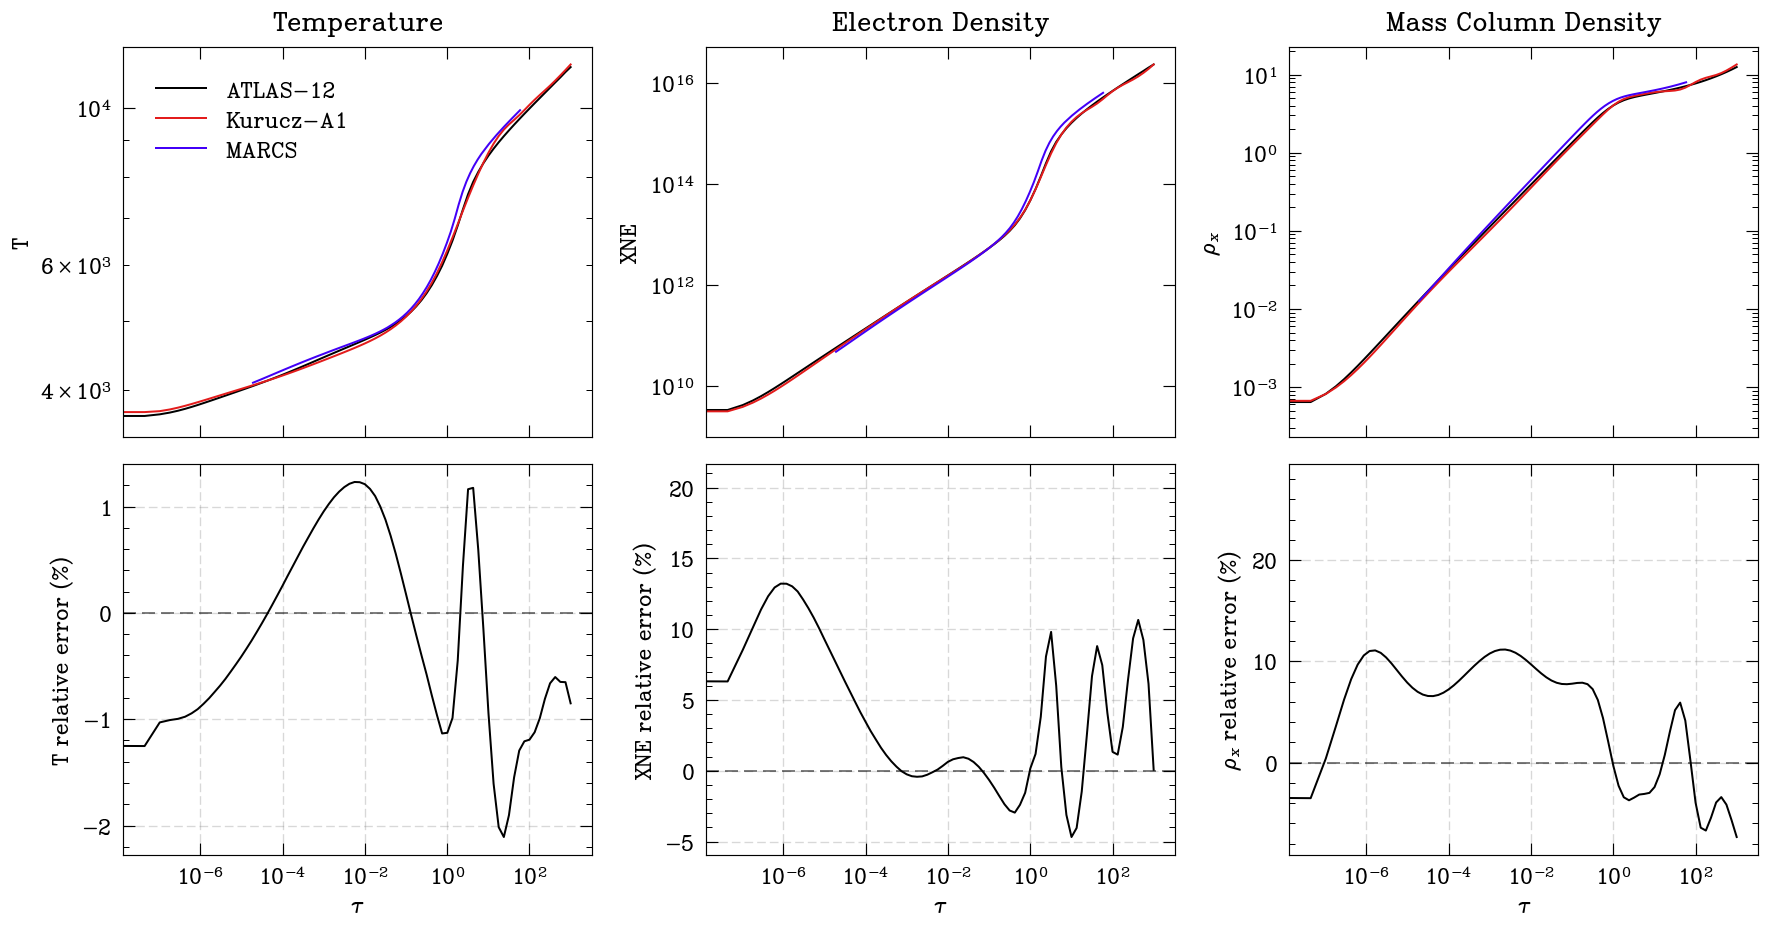

In [19]:
# Create a 2×3 subplot layout (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex='col')

# Top row - original comparison plots
ax1, ax2, ax3 = axs[0]
ax1.plot(solar_a['tau'], solar_a['temp'], label='ATLAS-12')
ax1.plot(solar_k['tau'], solar_k['temp'], label='Kurucz-A1')
ax1.plot(solar_marcs['tau'], solar_marcs['temp'], label='MARCS')
ax1.set_ylabel(r'T')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.set_title('Temperature')

ax2.plot(solar_a['tau'], solar_a['xne'], label='ATLAS-12')
ax2.plot(solar_k['tau'], solar_k['xne'], label='Kurucz-A1')
ax2.plot(solar_marcs['tau'], solar_marcs['xne'], label='MARCS')
ax2.set_ylabel(r'XNE')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title('Electron Density')

ax3.plot(solar_a['tau'], solar_a['rhox'], label='ATLAS-12')
ax3.plot(solar_k['tau'], solar_k['rhox'], label='Kurucz-A1')
ax3.plot(solar_marcs['tau'], solar_marcs['rhox'], label='MARCS')
ax3.set_ylabel(r'$\rho_x$')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_title('Mass Column Density')

# Bottom row - relative error plots
ax4, ax5, ax6 = axs[1]

# Create interpolation functions for ATLAS-12 data
from scipy.interpolate import interp1d

# Create common tau grid (using Kurucz's tau values)
common_tau = solar_k['tau']

# Create interpolation functions for ATLAS-12 data
f_temp_a = interp1d(solar_a['tau'], solar_a['temp'], bounds_error=False, fill_value='extrapolate')
f_xne_a = interp1d(solar_a['tau'], solar_a['xne'], bounds_error=False, fill_value='extrapolate')
f_rhox_a = interp1d(solar_a['tau'], solar_a['rhox'], bounds_error=False, fill_value='extrapolate')

# Calculate interpolated ATLAS-12 values at common tau points
temp_a_interp = f_temp_a(common_tau)
xne_a_interp = f_xne_a(common_tau)
rhox_a_interp = f_rhox_a(common_tau)

# Calculate relative errors as percentages: ((ATLAS-12 - Kurucz-A1) / Kurucz-A1) * 100
temp_rel_error = 100 * (temp_a_interp - solar_k['temp']) / solar_k['temp']
xne_rel_error = 100 * (xne_a_interp - solar_k['xne']) / solar_k['xne']
rhox_rel_error = 100 * (rhox_a_interp - solar_k['rhox']) / solar_k['rhox']

# Plot relative errors
ax4.plot(common_tau, temp_rel_error)
ax4.set_xlabel(r'$\tau$')
ax4.set_ylabel('T relative error (%)')
ax4.set_xscale('log')
ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax4.grid(True, alpha=0.3)

ax5.plot(common_tau, xne_rel_error)
ax5.set_xlabel(r'$\tau$')
ax5.set_ylabel('XNE relative error (%)')
ax5.set_xscale('log')
ax5.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax5.grid(True, alpha=0.3)

ax6.plot(common_tau, rhox_rel_error)
ax6.set_xlabel(r'$\tau$')
ax6.set_ylabel(r'$\rho_x$ relative error (%)')
ax6.set_xscale('log')
ax6.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()